### 1. Preparação dos Dados

Nesta etapa, realizamos o carregamento, a limpeza e a preparação dos dados para as análises subsequentes. Utilizamos a biblioteca `pandas` para manipular os DataFrames.

**1.1. Importação dos Arquivos CSV:**
Os seguintes arquivos CSV foram importados para o ambiente de análise:
- `olist_orders_dataset.csv`
- `olist_order_items_dataset.csv`
- `olist_customers_dataset.csv`
- `olist_products_dataset.csv`
- `olist_order_payments_dataset.csv`
- `product_category_name_translation.csv`
- `olist_geolocation_dataset.csv`
- `olist_sellers_dataset.csv`

**1.2. Limpeza dos Dados:**
Foram realizadas as seguintes etapas de limpeza:
- Remoção de linhas com valores nulos na coluna `order_delivered_customer_date` do DataFrame `df_orders` para garantir a integridade das análises de tempo de entrega.
- Preenchimento de valores nulos na coluna `order_approved_at` com os valores da coluna `order_purchase_timestamp` no DataFrame `df_orders`, assumindo que a aprovação ocorreu no momento da compra nesses casos.
- Remoção de linhas com valores nulos em colunas essenciais dos DataFrames `df_products` (peso, dimensões, categoria).

**1.3. Normalização de Colunas:**
Os nomes de todas as colunas dos DataFrames foram convertidos para letras minúsculas e espaços foram substituídos por underscores (`snake_case`) para facilitar a referência e a manipulação das colunas.

**1.4. Modelo Relacional e Conexão das Tabelas:**
Para realizar as diversas análises, os DataFrames foram combinados utilizando a função `pd.merge` do pandas, com base nas colunas de chave primária e estrangeira correspondentes. Por exemplo:
- `df_orders` foi unido a `df_customers` usando a coluna `customer_id`.
- `df_orders` foi unido a `df_items` usando a coluna `order_id`.
- `df_items` foi unido a `df_products` usando a coluna `product_id`.
- Outras uniões foram realizadas conforme a necessidade de cada análise.

Esses passos de preparação garantiram que os dados estivessem em um formato adequado para a exploração e a análise subsequentes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import sqlite3

# Caminhos dos arquivos
caminho_arquivo_orders = 'olist_ecommerce_data/olist_orders_dataset.csv'
caminho_arquivo_items = 'olist_ecommerce_data/olist_order_items_dataset.csv'
caminho_arquivo_customers = 'olist_ecommerce_data/olist_customers_dataset.csv'
caminho_arquivo_products = 'olist_ecommerce_data/olist_products_dataset.csv'
caminho_arquivo_payments = 'olist_ecommerce_data/olist_order_payments_dataset.csv'
caminho_arquivo_translation = 'olist_ecommerce_data/product_category_name_translation.csv'
caminho_arquivo_geolocation = 'olist_ecommerce_data/olist_geolocation_dataset.csv'
caminho_arquivo_sellers = 'olist_ecommerce_data/olist_sellers_dataset.csv'

# Carregamento dos datasets
df_orders = pd.read_csv(caminho_arquivo_orders)
df_items = pd.read_csv(caminho_arquivo_items)
df_customers = pd.read_csv(caminho_arquivo_customers)
df_products = pd.read_csv(caminho_arquivo_products)
df_payments = pd.read_csv(caminho_arquivo_payments)
df_translation = pd.read_csv(caminho_arquivo_translation)
df_geolocation = pd.read_csv(caminho_arquivo_geolocation)
df_sellers = pd.read_csv(caminho_arquivo_sellers)

# --- Limpeza dos DataFrames ---
# df_orders
df_orders_cleaned = df_orders.dropna(subset=['order_delivered_customer_date']).copy()
df_orders_cleaned['order_approved_at'] = df_orders_cleaned['order_approved_at'].fillna(df_orders_cleaned['order_purchase_timestamp'])
df_orders_cleaned.columns = df_orders_cleaned.columns.str.lower().str.replace(' ', '_')

# df_products
df_products_cleaned = df_products.dropna(subset=['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']).copy()
df_products_cleaned = df_products_cleaned.dropna(subset=['product_category_name']).copy()
df_products_cleaned.columns = df_products_cleaned.columns.str.lower().str.replace(' ', '_')

# Normalização de colunas dos outros DataFrames
df_items.columns = df_items.columns.str.lower().str.replace(' ', '_')
df_customers.columns = df_customers.columns.str.lower().str.replace(' ', '_')
df_payments.columns = df_payments.columns.str.lower().str.replace(' ', '_')
df_translation.columns = df_translation.columns.str.lower().str.replace(' ', '_')
df_geolocation.columns = df_geolocation.columns.str.lower().str.replace(' ', '_')
df_sellers.columns = df_sellers.columns.str.lower().str.replace(' ', '_')

# --- Verificação de valores nulos ---
print("--- Valores nulos ---")
print("df_items:\n", df_items.isnull().sum())
print("\ndf_customers:\n", df_customers.isnull().sum())
print("\ndf_payments:\n", df_payments.isnull().sum())
print("\ndf_translation:\n", df_translation.isnull().sum())
print("\ndf_orders_cleaned:\n", df_orders_cleaned.isnull().sum())
print("\ndf_products_cleaned:\n", df_products_cleaned.isnull().sum())
print("\ndf_sellers:\n", df_sellers.isnull().sum())
print("\ndf_geolocation:\n", df_geolocation.isnull().sum())

--- Valores nulos ---
df_items:
 order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

df_customers:
 customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

df_payments:
 order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

df_translation:
 product_category_name            0
product_category_name_english    0
dtype: int64

df_orders_cleaned:
 order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     1
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

df_products_cleaned:
 prod

### 2. Análise Exploratória de Dados

Nesta seção, realizamos uma análise exploratória dos dados para responder às perguntas propostas no teste, utilizando tanto Python com as bibliotecas `pandas`, `matplotlib` e `seaborn`, quanto consultas em SQL (quando aplicável).

#### a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

Para analisar o volume de pedidos ao longo do tempo e identificar possíveis padrões de sazonalidade, realizamos os seguintes passos:

1.  Convertemos a coluna `order_purchase_timestamp` para o tipo datetime.
2.  Extraímos o ano (`purchase_year`) e o mês (`purchase_month`) da data de compra.
3.  Agrupamos os dados por ano e mês, contando o número de pedidos em cada período.
4.  Criamos uma nova coluna `mes_ano` para facilitar a visualização da série temporal.
5.  Utilizamos um gráfico de linha (`seaborn.lineplot`) para visualizar a evolução do volume de pedidos por mês ao longo dos anos.


A análise visual do gráfico de linha permite identificar tendências de crescimento ou declínio no volume de pedidos ao longo do tempo, bem como possíveis picos ou quedas que podem indicar sazonalidade (por exemplo, aumento de vendas em datas comemorativas ou períodos específicos do ano).

#### b) Qual a distribuição do tempo de entrega dos pedidos?

Para entender a distribuição do tempo de entrega dos pedidos, calculamos a diferença em dias entre a data de aprovação do pedido (`order_approved_at`) e a data de entrega ao cliente (`order_delivered_customer_date`). Os passos foram:

1.  Convertemos as colunas `order_delivered_customer_date` e `order_approved_at` para o tipo datetime, tratando possíveis erros de parsing.
2.  Removemos linhas onde as datas de entrega ou aprovação estavam ausentes.
3.  Calculamos a diferença entre as datas e extraímos o número de dias, armazenando na coluna `tempo_entrega`.
4.  Apresentamos algumas linhas do DataFrame com as colunas relevantes para inspeção.
5.  Calculamos estatísticas descritivas (média, mediana, desvio padrão, etc.) do tempo de entrega para obter um resumo da sua distribuição.
6.  Utilizamos um histograma (`seaborn.histplot`) com uma estimativa de densidade do kernel (KDE) para visualizar a frequência dos diferentes tempos de entrega.
7.  Utilizamos um boxplot (`seaborn.boxplot`) para identificar a mediana, os quartis e possíveis outliers na distribuição do tempo de entrega.

A análise da distribuição do tempo de entrega nos fornece insights sobre a eficiência logística da empresa, identificando a faixa de tempo de entrega mais comum, a variabilidade e a presença de entregas muito rápidas ou muito lentas.

#### c) Qual a relação entre o valor do frete e a distância de entrega?

#### d) Quais são as categorias de produtos mais vendidas em termos de faturamento?


#### e) Quais estados brasileiros possuem o maior valor médio de pedido?


**Análises Adicionais Exploratórias do Tempo de Entrega:**

Além das perguntas diretas, também exploramos o tempo médio de entrega por estado do cliente e por categoria de produto para identificar possíveis variações geográficas ou relacionadas ao tipo de produto.

Essas análises exploratórias iniciais nos ajudam a entender melhor o comportamento dos dados e a identificar padrões que podem ser relevantes para as etapas subsequentes de solução de problemas de negócio.

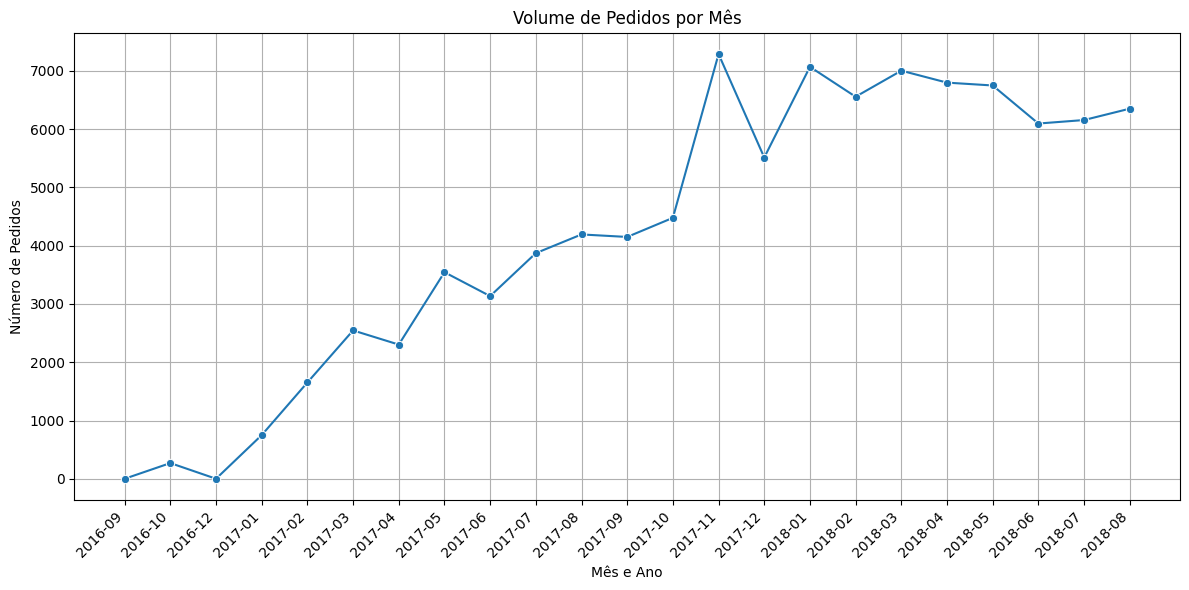

    order_approved_at order_delivered_customer_date  tempo_entrega
0 2017-10-02 11:07:15           2017-10-10 21:25:13              8
1 2018-07-26 03:24:27           2018-08-07 15:27:45             12
2 2018-08-08 08:55:23           2018-08-17 18:06:29              9
3 2017-11-18 19:45:59           2017-12-02 00:28:42             13
4 2018-02-13 22:20:29           2018-02-16 18:17:02              2

--- Estatísticas Descritivas do Tempo de Entrega (em dias) ---
count    96476.000000
mean        11.643124
std          9.520112
min         -7.000000
25%          6.000000
50%          9.000000
75%         15.000000
max        208.000000
Name: tempo_entrega, dtype: float64


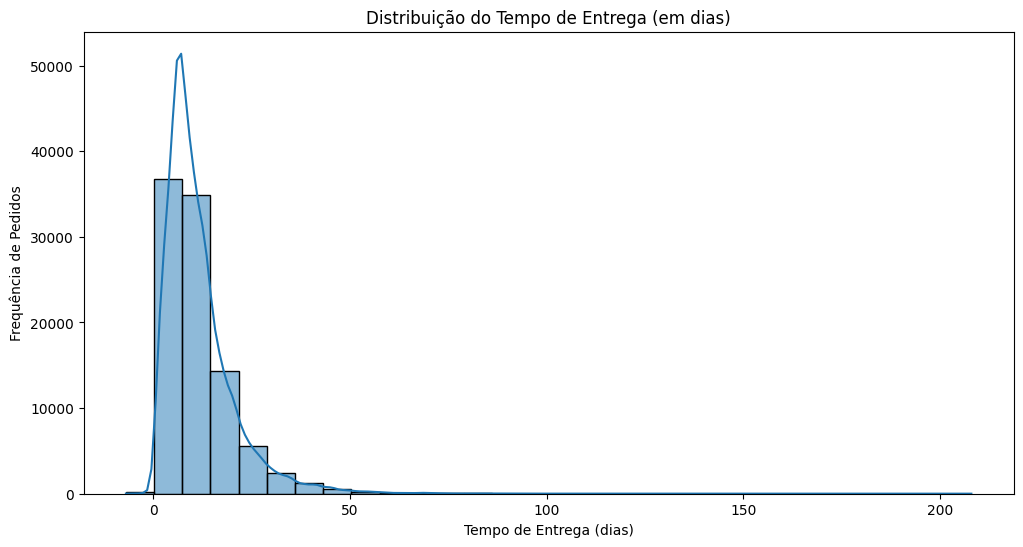

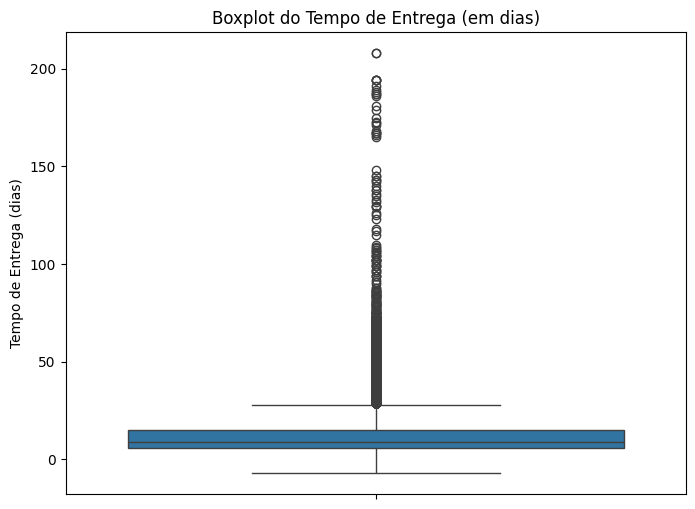


--- Tempo Médio de Entrega por Estado do Cliente ---
customer_state
SP     7.867761
PR    11.049766
MG    11.104800
DF    12.059135
SC    13.997745
RS    14.309506
RJ    14.443293
GO    14.610118
MS    14.700428
ES    14.861654
TO    16.624088
MT    16.998871
PE    17.512869
RN    18.343882
RO    18.345679
BA    18.361179
PI    18.565126
PB    19.357834
AC    19.925000
CE    20.331509
MA    20.511855
SE    20.608955
PA    22.774841
AL    23.541562
AM    25.537931
AP    26.074627
RR    28.560976
Name: tempo_entrega, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_13744\722068214.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tempo_medio_entrega_estado.index, y=tempo_medio_entrega_estado.values, palette='viridis')


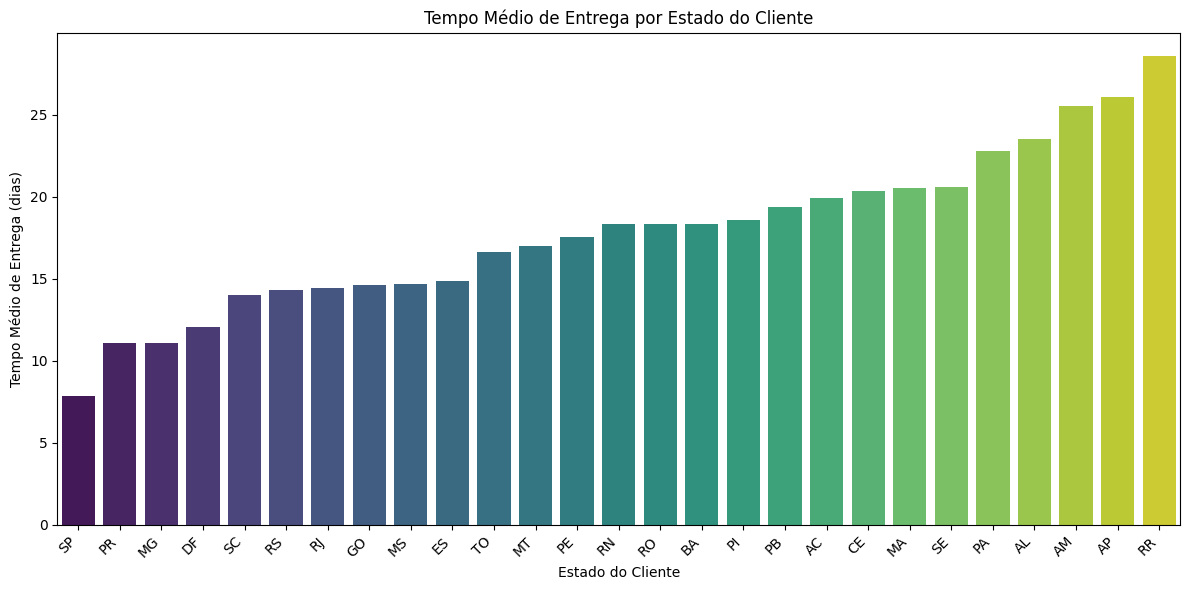


--- Tempo Médio de Entrega por Categoria de Produto ---
product_category_name
artes_e_artesanato                                4.500000
la_cuisine                                        6.928571
portateis_cozinha_e_preparadores_de_alimentos     7.142857
livros_importados                                 7.175439
fashion_roupa_infanto_juvenil                     7.714286
                                                   ...    
casa_conforto_2                                  13.666667
seguros_e_servicos                               14.000000
fashion_calcados                                 14.634241
artigos_de_natal                                 14.840000
moveis_escritorio                                19.748201
Name: tempo_entrega, Length: 73, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_13744\722068214.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_categorias.index, y=top_20_categorias.values, palette='magma')


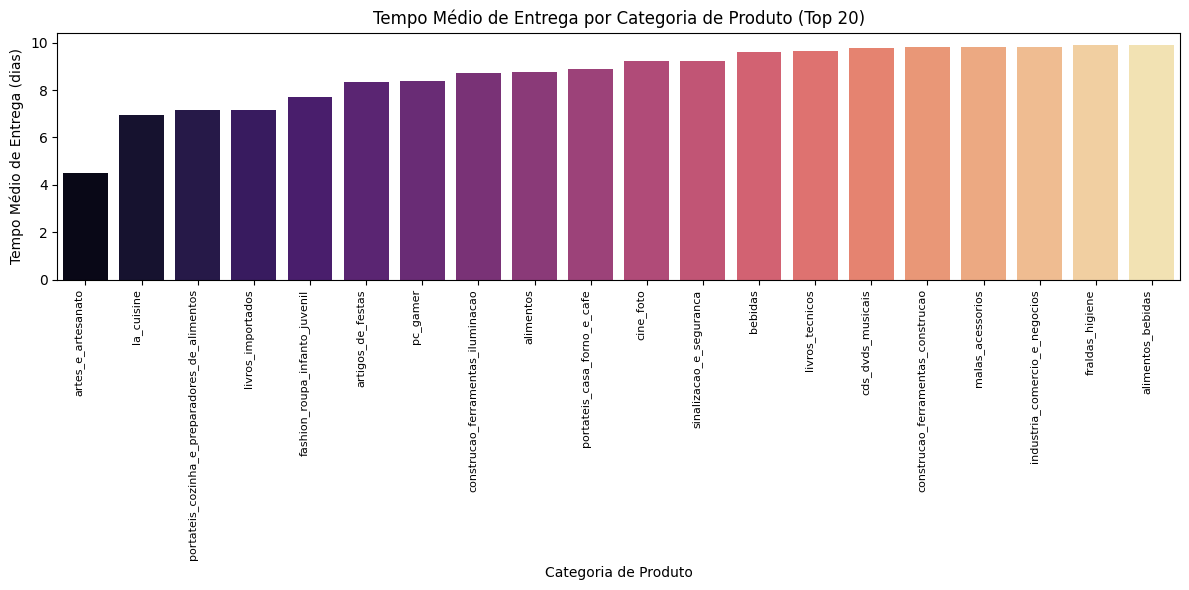


--- Tempo Médio de Entrega por Estado do Cliente e Categoria de Produto ---
product_category_name  agro_industria_e_comercio   alimentos  \
customer_state                                                 
AC                                           NaN         NaN   
AL                                          44.0   11.000000   
AM                                           NaN  138.000000   
AP                                          13.0         NaN   
BA                                          18.2   17.333333   

product_category_name  alimentos_bebidas  artes  artes_e_artesanato  \
customer_state                                                        
AC                                   NaN    NaN                 NaN   
AL                                  20.0    NaN                 NaN   
AM                                   NaN   32.0                 NaN   
AP                                   NaN   23.0                 NaN   
BA                                  10.0   15.2 

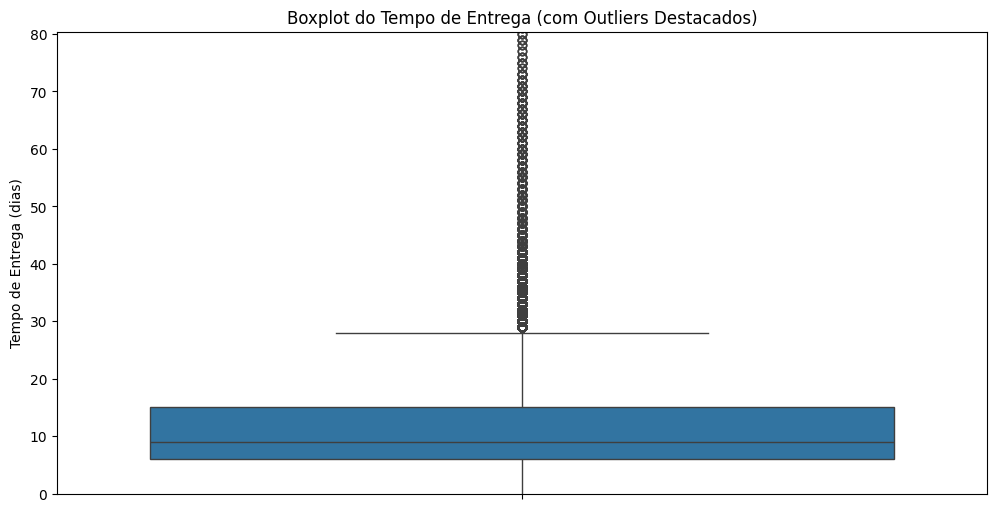


--- Volume de Pedidos por Mês (SQL) ---
    mes_ano  total_pedidos
0   2016-09              1
1   2016-10            270
2   2016-12              1
3   2017-01            750
4   2017-02           1653
5   2017-03           2546
6   2017-04           2303
7   2017-05           3545
8   2017-06           3135
9   2017-07           3872
10  2017-08           4193
11  2017-09           4150
12  2017-10           4478
13  2017-11           7288
14  2017-12           5513
15  2018-01           7069
16  2018-02           6556
17  2018-03           7003
18  2018-04           6798
19  2018-05           6749
20  2018-06           6096
21  2018-07           6156
22  2018-08           6351


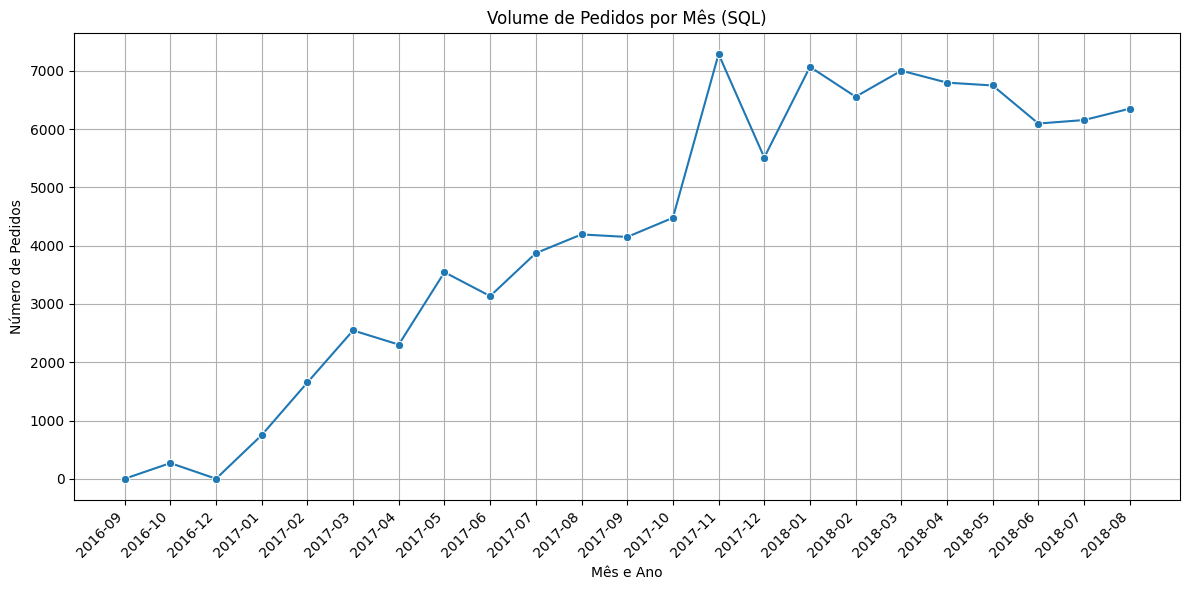


--- Distribuição do Tempo de Entrega dos Pedidos (SQL) ---
       tempo_entrega
count   96476.000000
mean       11.643756
std         9.519216
min        -6.000000
25%         6.000000
50%         9.000000
75%        15.000000
max       208.000000


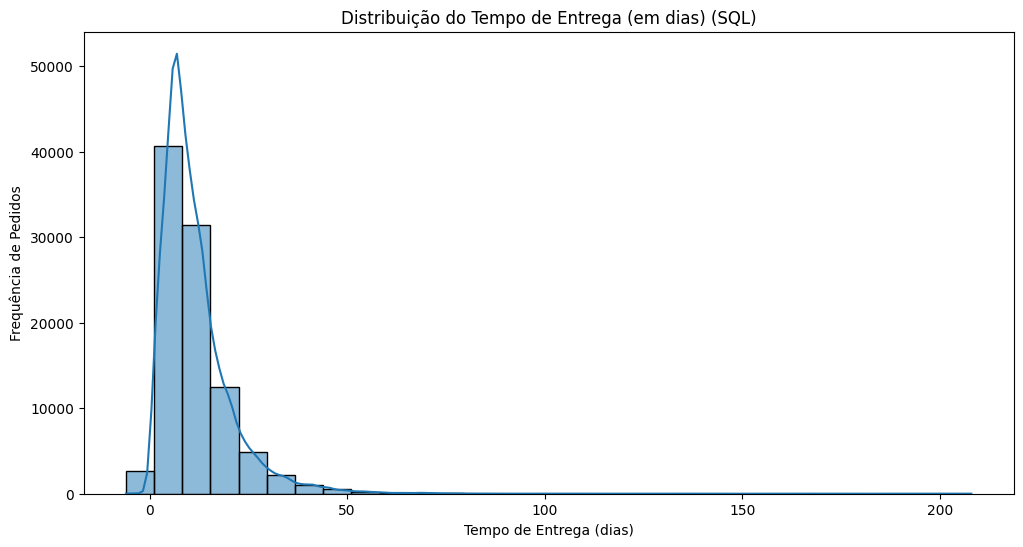

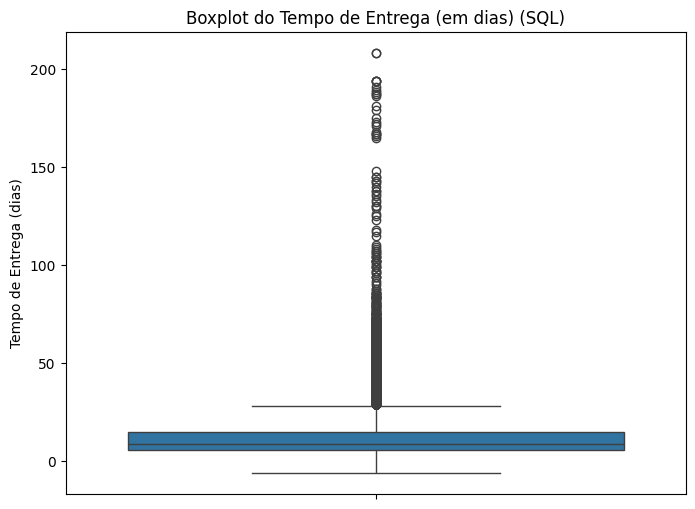


--- Faturamento por Categoria de Produto (SQL - Top 10) ---
    product_category_name  faturamento_total
0            beleza_saude         1258681.34
1      relogios_presentes         1205005.68
2         cama_mesa_banho         1036988.68
3           esporte_lazer          988048.97
4  informatica_acessorios          911954.32
5        moveis_decoracao          729762.49
6              cool_stuff          635290.85
7   utilidades_domesticas          632248.66
8              automotivo          592720.11
9      ferramentas_jardim          485256.46


C:\Users\User\AppData\Local\Temp\ipykernel_13744\722068214.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product_category_name', y='faturamento_total', data=faturamento_categorias_sql.head(10), palette='viridis')


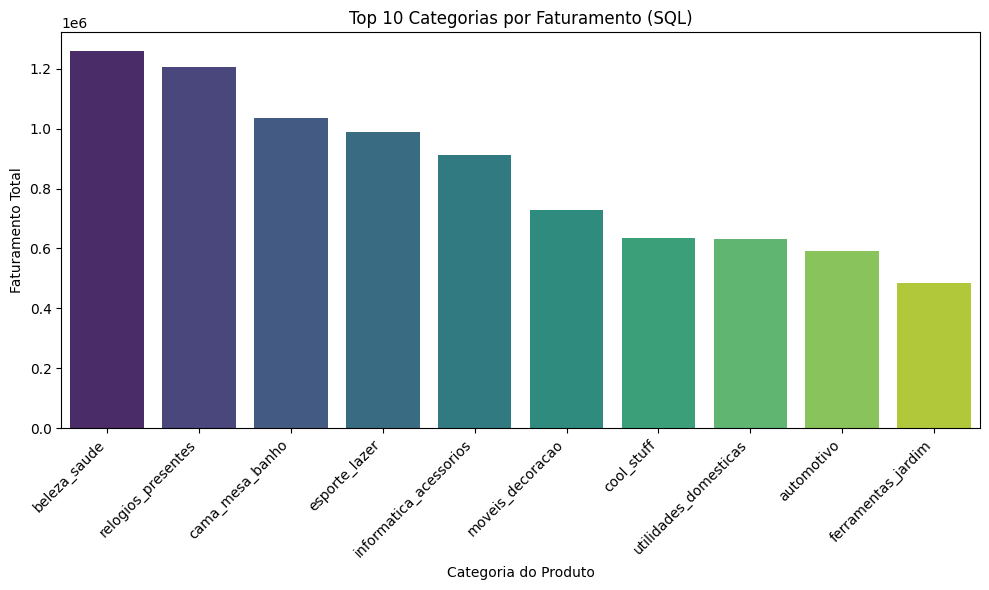


--- Valor Médio de Pedido por Estado (SQL - Top 10) ---
  customer_state  valor_medio_pedido
0             PB          192.127679
1             AL          184.673817
2             AC          175.065604
3             RO          167.336117
4             PA          165.531869
5             AP          165.121111
6             PI          161.990440
7             RN          157.592438
8             TO          156.137129
9             CE          154.107560


C:\Users\User\AppData\Local\Temp\ipykernel_13744\722068214.py:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_state', y='valor_medio_pedido', data=valor_medio_pedido_estado_sql.head(10), palette='magma')


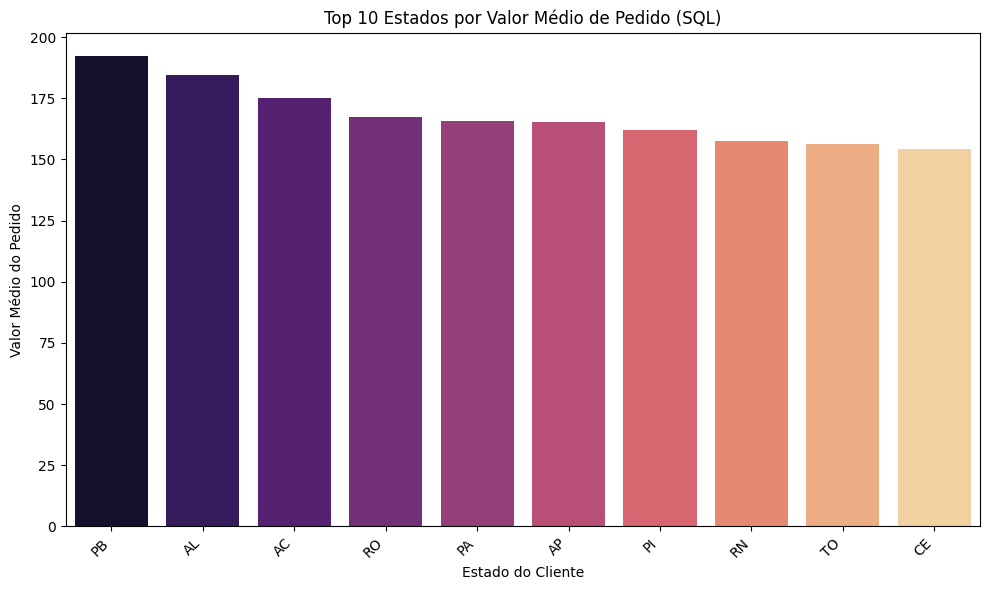


--- Correlação entre Valor do Frete e Distância de Entrega: 0.3894 ---


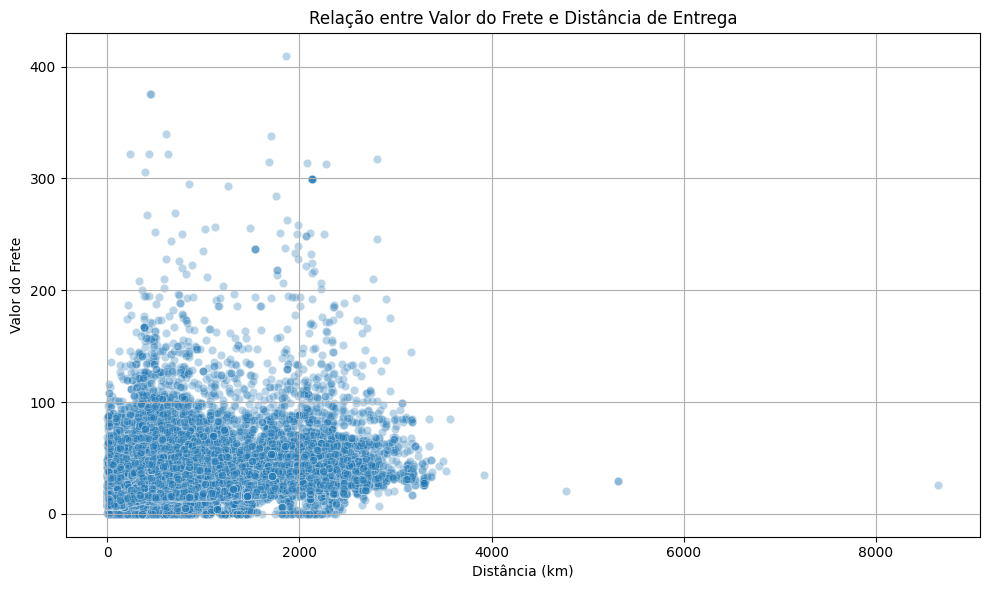


--- Volume Total de Pedidos por Mês (Sazonalidade Anual) ---
    mês  total_pedidos
0     1           7819
1     2           8209
2     3           9549
3     4           9101
4     5          10294
5     6           9231
6     7          10028
7     8          10544
8     9           4151
9    10           4748
10   11           7288
11   12           5514


C:\Users\User\AppData\Local\Temp\ipykernel_13744\722068214.py:258: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mês', y='total_pedidos', data=volume_pedidos_anual, palette='viridis')


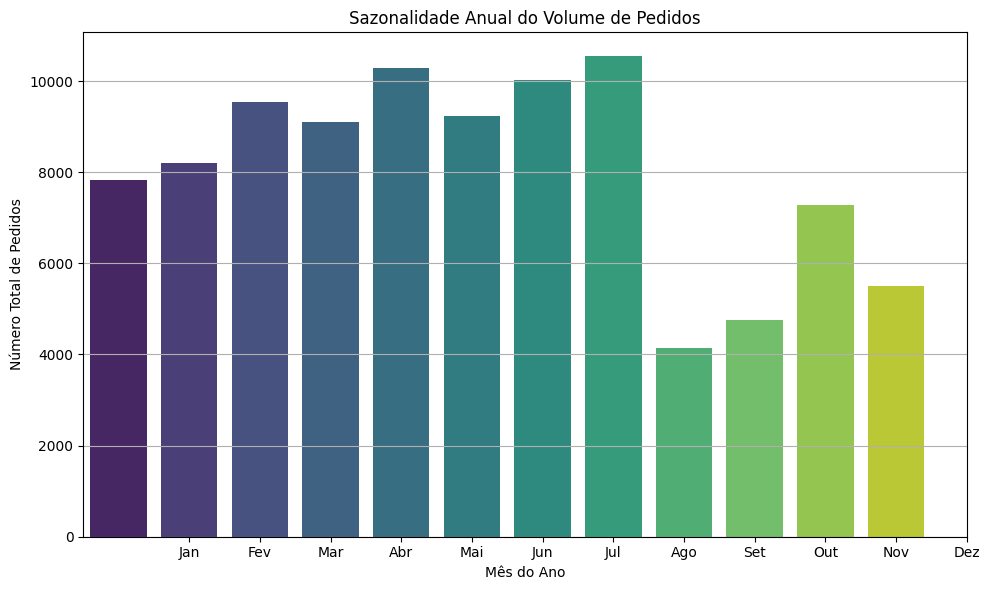

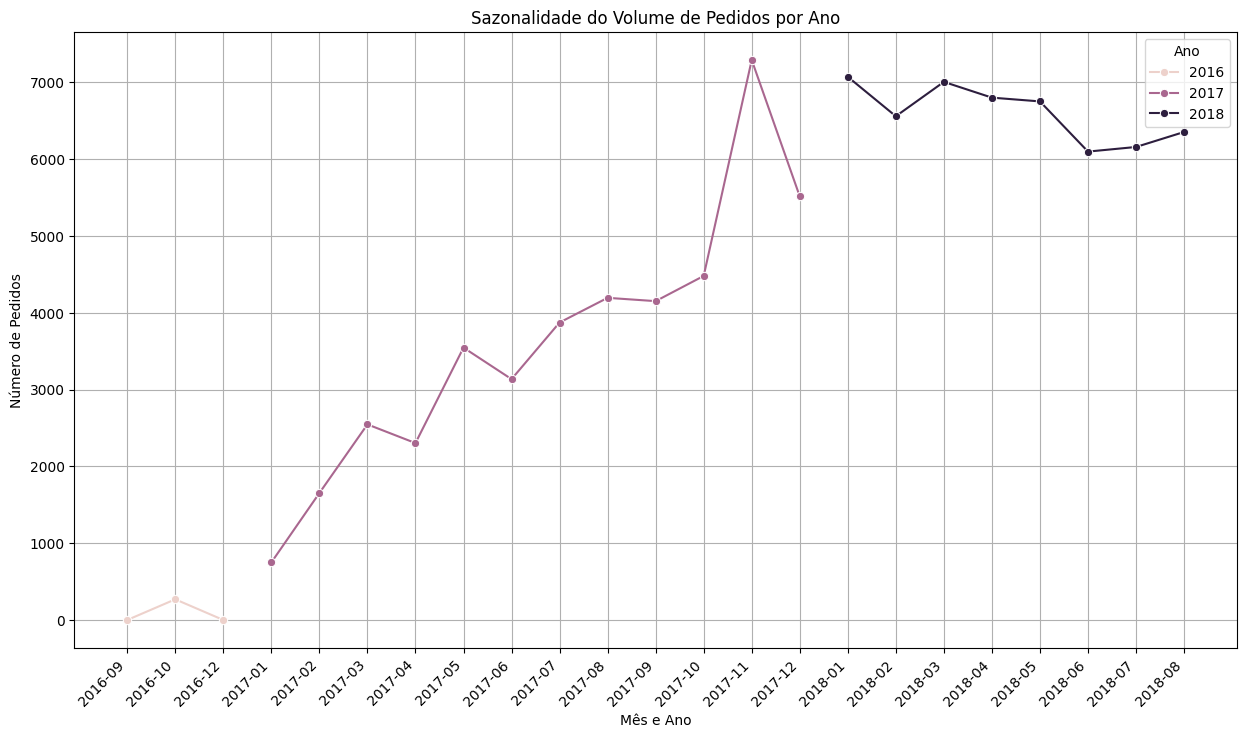


--- Tempo Médio de Entrega por Estado do Cliente ---
customer_state
SP     7.867761
PR    11.049766
MG    11.104800
DF    12.059135
SC    13.997745
RS    14.309506
RJ    14.443293
GO    14.610118
MS    14.700428
ES    14.861654
TO    16.624088
MT    16.998871
PE    17.512869
RN    18.343882
RO    18.345679
BA    18.361179
PI    18.565126
PB    19.357834
AC    19.925000
CE    20.331509
MA    20.511855
SE    20.608955
PA    22.774841
AL    23.541562
AM    25.537931
AP    26.074627
RR    28.560976
Name: tempo_entrega, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_13744\722068214.py:287: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tempo_medio_entrega_estado.index, y=tempo_medio_entrega_estado.values, palette='viridis')


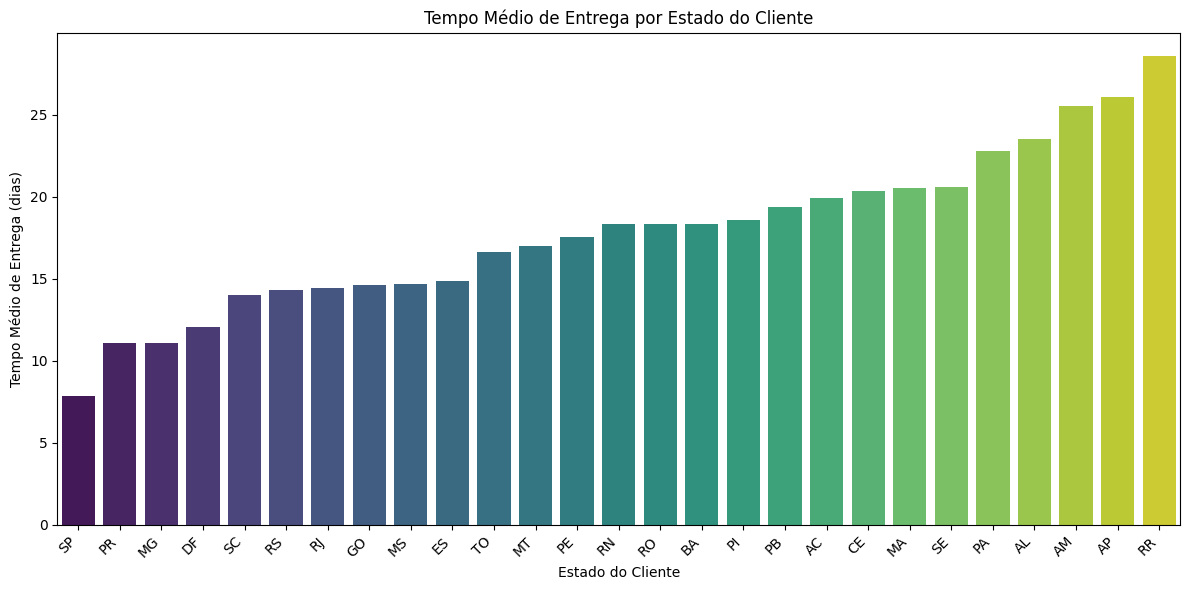


--- Tempo Médio de Entrega por Categoria de Produto ---
product_category_name
artes_e_artesanato                                4.500000
la_cuisine                                        6.928571
portateis_cozinha_e_preparadores_de_alimentos     7.142857
livros_importados                                 7.175439
fashion_roupa_infanto_juvenil                     7.714286
                                                   ...    
casa_conforto_2                                  13.666667
seguros_e_servicos                               14.000000
fashion_calcados                                 14.634241
artigos_de_natal                                 14.840000
moveis_escritorio                                19.748201
Name: tempo_entrega, Length: 73, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_13744\722068214.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_categorias.index, y=top_20_categorias.values, palette='magma')


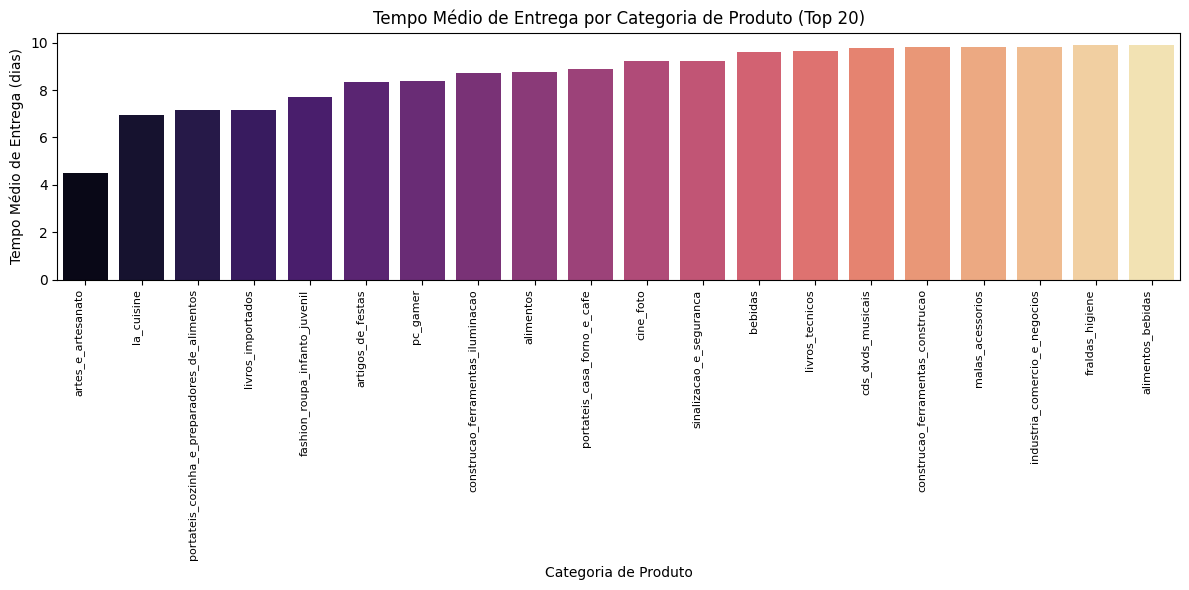


--- Top 20 Vendedores por Faturamento ---
seller_id
4869f7a5dfa277a7dca6462dcf3b52b2    229472.63
53243585a1d6dc2643021fd1853d8905    222776.05
4a3ca9315b744ce9f8e9374361493884    200472.92
fa1c13f2614d7b5c4749cbc52fecda94    194042.03
7c67e1448b00f6e969d365cea6b010ab    187923.89
7e93a43ef30c4f03f38b393420bc753a    176431.87
da8622b14eb17ae2831f4ac5b9dab84a    160236.57
7a67c85e85bb2ce8582c35f2203ad736    141745.53
1025f0e2d44d7041d6cf58b6550e0bfa    138968.55
955fee9216a65b617aa5c0531780ce60    135171.70
46dc3b2cc0980fb8ec44634e21d2718e    128111.19
6560211a19b47992c3666cc44a7e94c0    123304.83
620c87c171fb2a6dd6e8bb4dec959fc6    114774.50
7d13fca15225358621be4086e1eb0964    113628.97
5dceca129747e92ff8ef7a997dc4f8ca    112155.53
1f50f920176fa81dab994f9023523100    106939.21
cc419e0650a3c5ba77189a1882b7556a    104288.42
a1043bafd471dff536d0c462352beb48    101901.16
3d871de0142ce09b7081e2b9d1733cb1     94914.20
edb1ef5e36e0c8cd84eb3c9b003e486d     79284.55
Name: price, dtype: float64

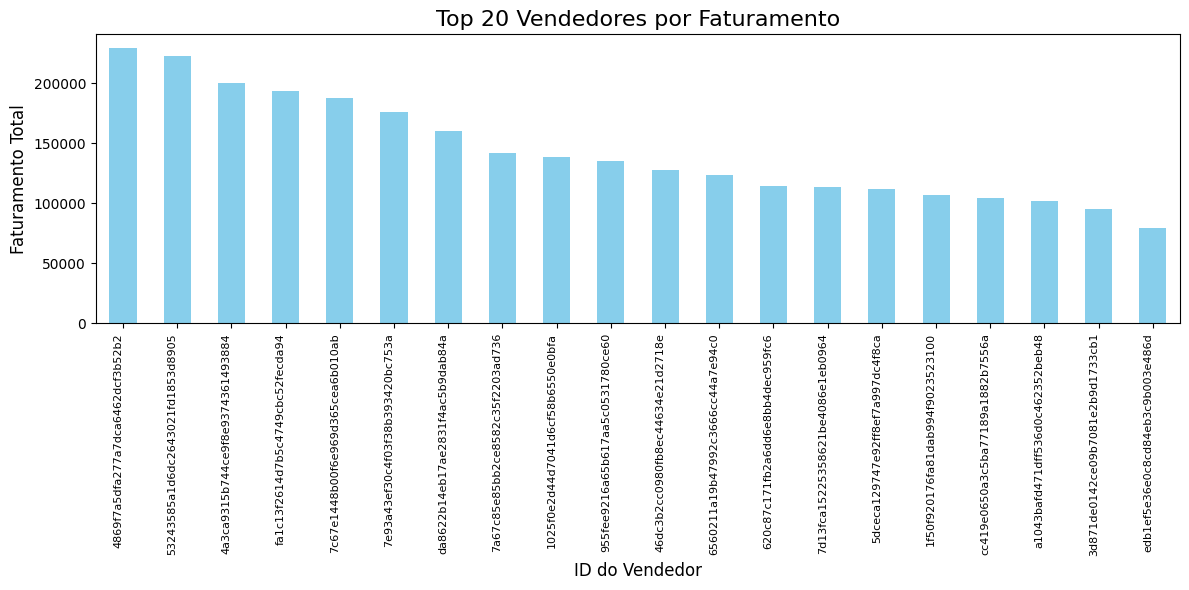


--- Top 20 Vendedores com Menor Tempo Médio de Envio (em dias) ---
seller_id
466222e777149751370e7e98fb623b0c    2.000000
ee2fbacc2fc3794e656cc4d933d59ce7    2.000000
7d81e74a4755b552267cd5e081563028    2.000000
52a50b42accf164f9f019941e5759d9b    2.500000
0daf5180aa44356f60f8effa533b55a2    2.500000
392f7f2c797e4dc077e4311bde2ab8ce    2.500000
dc7192adf8ba09569261f4a8d576afe0    2.625000
651fe66032c9520ee5587f694908040d    2.714286
6c17baf138731a4aaacc3210adf2037b    2.800000
b494891378bd8f4560abe576c52deacd    2.857143
55dedd83e501d8248880557d9073cbfd    2.888889
67883baaae6134ee81b271a542613728    2.947368
3492e68f37fd1df87f4f2f2ea247f445    3.000000
377bc18334c78dd2f1535ef22a3ad225    3.000000
bc8c8d665ec4664d286be0d521722b19    3.000000
4fe2f67634d00c021aa01f96b6f2d68e    3.000000
3296662b1331dea51e744505065ae889    3.000000
fd435faa3c0422b60440ea3480d0e77c    3.000000
d13e50eaa47b4cbe9eb81465865d8cfc    3.205882
b2c97074649f92197d9387d9033dda5f    3.272727
Name: tempo_envio, dty

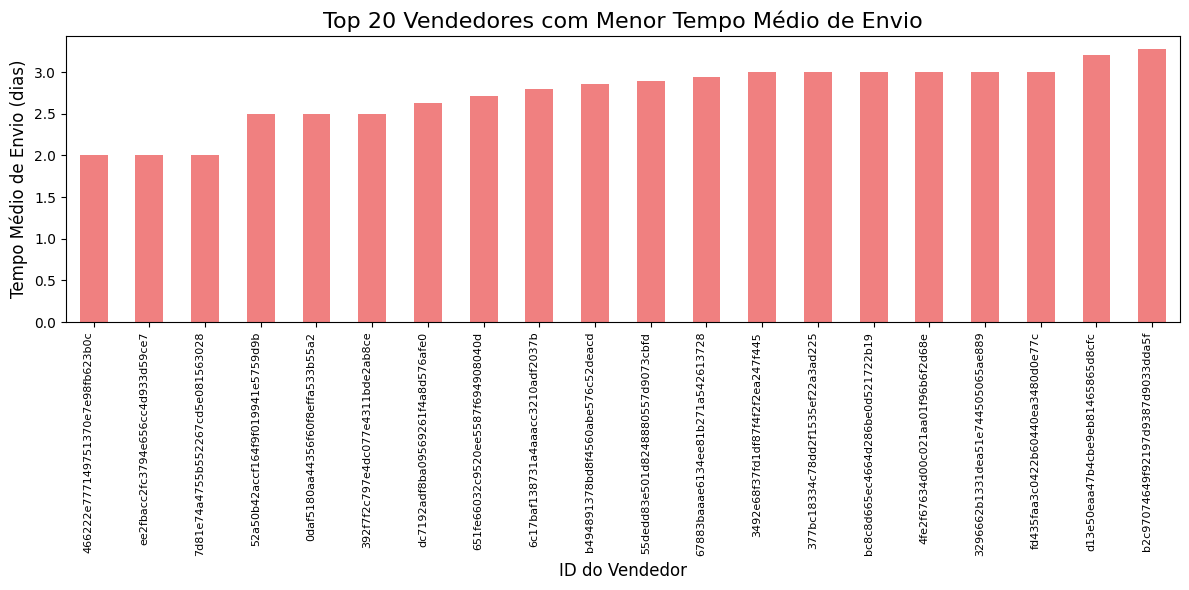

In [2]:
# --- Análise do Volume de Pedidos por Mês e Sazonalidade ---
df_orders_cleaned['order_purchase_timestamp'] = pd.to_datetime(df_orders_cleaned['order_purchase_timestamp'])
df_orders_cleaned['purchase_year'] = df_orders_cleaned['order_purchase_timestamp'].dt.year
df_orders_cleaned['purchase_month'] = df_orders_cleaned['order_purchase_timestamp'].dt.month

volume_pedidos_mensal = df_orders_cleaned.groupby(['purchase_year', 'purchase_month'])['order_id'].count().reset_index()
volume_pedidos_mensal.rename(columns={'order_id': 'total_pedidos'}, inplace=True)
volume_pedidos_mensal['mes_ano'] = volume_pedidos_mensal['purchase_year'].astype(str) + '-' + volume_pedidos_mensal['purchase_month'].astype(str).str.zfill(2)

plt.figure(figsize=(12, 6))
sns.lineplot(x='mes_ano', y='total_pedidos', data=volume_pedidos_mensal, marker='o')
plt.title('Volume de Pedidos por Mês')
plt.xlabel('Mês e Ano')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Análise do Tempo de Entrega ---
df_orders_cleaned['order_delivered_customer_date'] = pd.to_datetime(df_orders_cleaned['order_delivered_customer_date'], errors='coerce')
df_orders_cleaned['order_approved_at'] = pd.to_datetime(df_orders_cleaned['order_approved_at'], errors='coerce')
df_orders_cleaned.dropna(subset=['order_delivered_customer_date', 'order_approved_at'], inplace=True)
df_orders_cleaned['tempo_entrega'] = (df_orders_cleaned['order_delivered_customer_date'] - df_orders_cleaned['order_approved_at']).dt.days

print(df_orders_cleaned[['order_approved_at', 'order_delivered_customer_date', 'tempo_entrega']].head())
print("\n--- Estatísticas Descritivas do Tempo de Entrega (em dias) ---")
print(df_orders_cleaned['tempo_entrega'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(df_orders_cleaned['tempo_entrega'], bins=30, kde=True)
plt.title('Distribuição do Tempo de Entrega (em dias)')
plt.xlabel('Tempo de Entrega (dias)')
plt.ylabel('Frequência de Pedidos')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(y=df_orders_cleaned['tempo_entrega'])
plt.title('Boxplot do Tempo de Entrega (em dias)')
plt.ylabel('Tempo de Entrega (dias)')
plt.show()

# --- Análise do Tempo Médio de Entrega por Estado do Cliente ---
df_orders_estado = pd.merge(df_orders_cleaned, df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')
tempo_medio_entrega_estado = df_orders_estado.groupby('customer_state')['tempo_entrega'].mean().sort_values()
print("\n--- Tempo Médio de Entrega por Estado do Cliente ---")
print(tempo_medio_entrega_estado)
plt.figure(figsize=(12, 6))
sns.barplot(x=tempo_medio_entrega_estado.index, y=tempo_medio_entrega_estado.values, palette='viridis')
plt.title('Tempo Médio de Entrega por Estado do Cliente')
plt.xlabel('Estado do Cliente')
plt.ylabel('Tempo Médio de Entrega (dias)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Análise do Tempo Médio de Entrega por Categoria de Produto ---
df_pedidos_itens = pd.merge(df_orders_cleaned, df_items[['order_id', 'product_id']], on='order_id', how='left')
df_pedidos_produtos = pd.merge(df_pedidos_itens, df_products_cleaned[['product_id', 'product_category_name']], on='product_id', how='left')
df_pedidos_produtos = pd.merge(df_pedidos_produtos, df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')
tempo_medio_entrega_categoria = df_pedidos_produtos.groupby('product_category_name')['tempo_entrega'].mean().sort_values()
print("\n--- Tempo Médio de Entrega por Categoria de Produto ---")
print(tempo_medio_entrega_categoria)
plt.figure(figsize=(12, 6))
top_20_categorias = tempo_medio_entrega_categoria.head(20)
sns.barplot(x=top_20_categorias.index, y=top_20_categorias.values, palette='magma')
plt.title('Tempo Médio de Entrega por Categoria de Produto (Top 20)')
plt.xlabel('Categoria de Produto')
plt.ylabel('Tempo Médio de Entrega (dias)')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

# --- Tabela Dinâmica do Tempo Médio de Entrega por Estado e Categoria ---
pivot_tempo_entrega = df_pedidos_produtos.pivot_table(
    values='tempo_entrega',
    index='customer_state',
    columns='product_category_name',
    aggfunc='mean'
)
print("\n--- Tempo Médio de Entrega por Estado do Cliente e Categoria de Produto ---")
print(pivot_tempo_entrega.head())

# --- Análise de Outliers no Tempo de Entrega ---
limite_superior = df_orders_cleaned['tempo_entrega'].mean() + 3 * df_orders_cleaned['tempo_entrega'].std()
outliers_tempo_entrega = df_orders_cleaned[df_orders_cleaned['tempo_entrega'] > limite_superior]
print(f"\n--- Número de Outliers no Tempo de Entrega (> {limite_superior:.2f} dias): {len(outliers_tempo_entrega)}")
print("\n--- Exemplos de Pedidos com Tempo de Entrega Elevado ---")
print(outliers_tempo_entrega[['order_id', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'tempo_entrega']].head())
plt.figure(figsize=(12, 6))
sns.boxplot(y=df_orders_cleaned['tempo_entrega'])
plt.title('Boxplot do Tempo de Entrega (com Outliers Destacados)')
plt.ylabel('Tempo de Entrega (dias)')
plt.ylim(0, limite_superior * 2)
plt.show()

# Conectar a um banco de dados SQLite na memória
conn = sqlite3.connect(':memory:')

# Carregar DataFrames para tabelas SQL
df_orders_cleaned.to_sql('orders', conn, if_exists='replace', index=False)
df_payments.to_sql('payments', conn, if_exists='replace', index=False)
df_items.to_sql('items', conn, if_exists='replace', index=False)
df_products_cleaned.to_sql('products', conn, if_exists='replace', index=False)
df_customers.to_sql('customers', conn, if_exists='replace', index=False)

# Função para executar consultas SQL e retornar como DataFrame Pandas
def executar_sql(query):
    return pd.read_sql_query(query, conn)

# --- Tarefa 2: Análise Exploratória de Dados (Respostas com SQL e Visualizações) ---

# a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?
query_volume_mensal = """
SELECT
    strftime('%Y-%m', order_purchase_timestamp) AS mes_ano,
    COUNT(order_id) AS total_pedidos
FROM orders
GROUP BY mes_ano
ORDER BY mes_ano;
"""
volume_pedidos_mensal_sql = executar_sql(query_volume_mensal)
print("\n--- Volume de Pedidos por Mês (SQL) ---")
print(volume_pedidos_mensal_sql)

plt.figure(figsize=(12, 6))
sns.lineplot(x='mes_ano', y='total_pedidos', data=volume_pedidos_mensal_sql, marker='o')
plt.title('Volume de Pedidos por Mês (SQL)')
plt.xlabel('Mês e Ano')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# b) Qual a distribuição do tempo de entrega dos pedidos?
query_distribuicao_tempo_entrega = """
SELECT
    CAST((JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_approved_at)) AS INTEGER) AS tempo_entrega
FROM orders
WHERE order_delivered_customer_date IS NOT NULL AND order_approved_at IS NOT NULL;
"""
distribuicao_tempo_entrega_sql = executar_sql(query_distribuicao_tempo_entrega)
print("\n--- Distribuição do Tempo de Entrega dos Pedidos (SQL) ---")
print(distribuicao_tempo_entrega_sql.describe())

plt.figure(figsize=(12, 6))
sns.histplot(distribuicao_tempo_entrega_sql['tempo_entrega'], bins=30, kde=True)
plt.title('Distribuição do Tempo de Entrega (em dias) (SQL)')
plt.xlabel('Tempo de Entrega (dias)')
plt.ylabel('Frequência de Pedidos')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(y=distribuicao_tempo_entrega_sql['tempo_entrega'])
plt.title('Boxplot do Tempo de Entrega (em dias) (SQL)')
plt.ylabel('Tempo de Entrega (dias)')
plt.show()

# d) Quais são as categorias de produtos mais vendidas em termos de faturamento?
query_faturamento_categorias = """
SELECT
    p.product_category_name,
    SUM(oi.price) AS faturamento_total
FROM items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY faturamento_total DESC
LIMIT 10;
"""
faturamento_categorias_sql = executar_sql(query_faturamento_categorias)
print("\n--- Faturamento por Categoria de Produto (SQL - Top 10) ---")
print(faturamento_categorias_sql)

plt.figure(figsize=(10, 6))
sns.barplot(x='product_category_name', y='faturamento_total', data=faturamento_categorias_sql.head(10), palette='viridis')
plt.title('Top 10 Categorias por Faturamento (SQL)')
plt.xlabel('Categoria do Produto')
plt.ylabel('Faturamento Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# e) Quais estados brasileiros possuem o maior valor médio de pedido?
query_valor_medio_pedido_estado = """
SELECT
    c.customer_state,
    AVG(oi.price) AS valor_medio_pedido
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN items oi ON o.order_id = oi.order_id
GROUP BY c.customer_state
ORDER BY valor_medio_pedido DESC
LIMIT 10;
"""
valor_medio_pedido_estado_sql = executar_sql(query_valor_medio_pedido_estado)
print("\n--- Valor Médio de Pedido por Estado (SQL - Top 10) ---")
print(valor_medio_pedido_estado_sql)

plt.figure(figsize=(10, 6))
sns.barplot(x='customer_state', y='valor_medio_pedido', data=valor_medio_pedido_estado_sql.head(10), palette='magma')
plt.title('Top 10 Estados por Valor Médio de Pedido (SQL)')
plt.xlabel('Estado do Cliente')
plt.ylabel('Valor Médio do Pedido')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Análise da Relação entre Valor do Frete e Distância de Entrega ---
# (Mover para a seção c da AED)
# 1. Juntar DataFrames para obter dados de frete, vendedor e cliente
df_vendas_vendedor = pd.merge(df_items[['order_id', 'seller_id', 'freight_value']], df_sellers[['seller_id', 'seller_zip_code_prefix']], on='seller_id', how='left')
df_vendas_cliente = pd.merge(df_vendas_vendedor, df_orders[['order_id', 'customer_id']], on='order_id', how='left')
df_frete_distancia = pd.merge(df_vendas_cliente, df_customers[['customer_id', 'customer_zip_code_prefix']], on='customer_id', how='left')

# 2. Juntar coordenadas geográficas para vendedores e clientes
df_vendedor_geo = df_geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
df_vendedor_geo.rename(columns={'geolocation_zip_code_prefix': 'seller_zip_code_prefix', 'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'}, inplace=True)
df_frete_distancia = pd.merge(df_frete_distancia, df_vendedor_geo, on='seller_zip_code_prefix', how='left')

df_cliente_geo = df_geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
df_cliente_geo.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix', 'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'}, inplace=True)
df_frete_distancia = pd.merge(df_frete_distancia, df_cliente_geo, on='customer_zip_code_prefix', how='left')

# 3. Função para calcular distância geodésica
def calcular_distancia(row):
    try:
        seller_coord = (row['seller_lat'], row['seller_lng'])
        customer_coord = (row['customer_lat'], row['customer_lng'])
        return geodesic(seller_coord, customer_coord).km
    except (TypeError, ValueError):
        return np.nan

# 4. Calcular distância e correlação
df_frete_distancia['distancia_km'] = df_frete_distancia.apply(calcular_distancia, axis=1)
correlacao_frete_distancia = df_frete_distancia['freight_value'].corr(df_frete_distancia['distancia_km'])
print(f"\n--- Correlação entre Valor do Frete e Distância de Entrega: {correlacao_frete_distancia:.4f} ---")

# 5. Visualizar a relação
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distancia_km', y='freight_value', data=df_frete_distancia, alpha=0.3)
plt.title('Relação entre Valor do Frete e Distância de Entrega')
plt.xlabel('Distância (km)')
plt.ylabel('Valor do Frete')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Análise de Sazonalidade Anual e por Ano ---
# (Mover para a seção a da AED)
df_orders_cleaned['purchase_month_only'] = df_orders_cleaned['order_purchase_timestamp'].dt.month
volume_pedidos_anual = df_orders_cleaned.groupby('purchase_month_only')['order_id'].count().reset_index()
volume_pedidos_anual.rename(columns={'purchase_month_only': 'mês', 'order_id': 'total_pedidos'}, inplace=True)
volume_pedidos_anual = volume_pedidos_anual.sort_values(by='mês')
print("\n--- Volume Total de Pedidos por Mês (Sazonalidade Anual) ---")
print(volume_pedidos_anual)
plt.figure(figsize=(10, 6))
sns.barplot(x='mês', y='total_pedidos', data=volume_pedidos_anual, palette='viridis')
plt.title('Sazonalidade Anual do Volume de Pedidos')
plt.xlabel('Mês do Ano')
plt.ylabel('Número Total de Pedidos')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

volume_pedidos_mensal_anual = df_orders_cleaned.groupby(['purchase_year', 'purchase_month'])['order_id'].count().reset_index()
volume_pedidos_mensal_anual.rename(columns={'purchase_year': 'ano', 'purchase_month': 'mês', 'order_id': 'total_pedidos'}, inplace=True)
volume_pedidos_mensal_anual['mes_ano'] = volume_pedidos_mensal_anual['ano'].astype(str) + '-' + volume_pedidos_mensal_anual['mês'].astype(str).str.zfill(2)
plt.figure(figsize=(15, 8))
sns.lineplot(x='mes_ano', y='total_pedidos', hue='ano', data=volume_pedidos_mensal_anual, marker='o')
plt.title('Sazonalidade do Volume de Pedidos por Ano')
plt.xlabel('Mês e Ano')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ano')
plt.grid(True)
plt.show()

# --- Análise do Tempo Médio de Entrega por Estado do Cliente ---
# (Mover para a seção b da AED - extensão)
df_orders_estado = pd.merge(df_orders_cleaned, df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')
tempo_medio_entrega_estado = df_orders_estado.groupby('customer_state')['tempo_entrega'].mean().sort_values()
print("\n--- Tempo Médio de Entrega por Estado do Cliente ---")
print(tempo_medio_entrega_estado)
plt.figure(figsize=(12, 6))
sns.barplot(x=tempo_medio_entrega_estado.index, y=tempo_medio_entrega_estado.values, palette='viridis')
plt.title('Tempo Médio de Entrega por Estado do Cliente')
plt.xlabel('Estado do Cliente')
plt.ylabel('Tempo Médio de Entrega (dias)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Análise do Tempo Médio de Entrega por Categoria de Produto ---
# (Mover para a seção b da AED - extensão)
df_pedidos_itens = pd.merge(df_orders_cleaned, df_items[['order_id', 'product_id']], on='order_id', how='left')
df_pedidos_produtos = pd.merge(df_pedidos_itens, df_products_cleaned[['product_id', 'product_category_name']], on='product_id', how='left')
df_pedidos_produtos = pd.merge(df_pedidos_produtos, df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')
tempo_medio_entrega_categoria = df_pedidos_produtos.groupby('product_category_name')['tempo_entrega'].mean().sort_values()
print("\n--- Tempo Médio de Entrega por Categoria de Produto ---")
print(tempo_medio_entrega_categoria)
plt.figure(figsize=(12, 6))
top_20_categorias = tempo_medio_entrega_categoria.head(20)
sns.barplot(x=top_20_categorias.index, y=top_20_categorias.values, palette='magma')
plt.title('Tempo Médio de Entrega por Categoria de Produto (Top 20)')
plt.xlabel('Categoria de Produto')
plt.ylabel('Tempo Médio de Entrega (dias)')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

# --- Análise dos Top 20 Vendedores por Faturamento ---
# (Mover para uma nova seção f da AED - Análise de Vendedores)
faturamento_vendedor = df_items.groupby('seller_id')['price'].sum().sort_values(ascending=False).head(20)
print("\n--- Top 20 Vendedores por Faturamento ---")
print(faturamento_vendedor)
plt.figure(figsize=(12, 6))
faturamento_vendedor.plot(kind='bar', color='skyblue')
plt.title('Top 20 Vendedores por Faturamento', fontsize=16)
plt.xlabel('ID do Vendedor', fontsize=12)
plt.ylabel('Faturamento Total', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

# --- Análise dos Top 20 Vendedores com Menor Tempo Médio de Envio ---
# (Mover para a seção f da AED - Análise de Vendedores)
df_envio_vendedor = pd.merge(df_orders_cleaned[['order_id', 'order_purchase_timestamp']],
                             df_items[['order_id', 'seller_id', 'shipping_limit_date']],
                             on='order_id', how='inner')

# Converter as colunas para datetime, garantindo que estão no formato correto
df_envio_vendedor['shipping_limit_date'] = pd.to_datetime(df_envio_vendedor['shipping_limit_date'])
df_envio_vendedor['order_purchase_timestamp'] = pd.to_datetime(df_envio_vendedor['order_purchase_timestamp'])

# Agora a subtração deve funcionar corretamente
df_envio_vendedor['tempo_envio'] = (df_envio_vendedor['shipping_limit_date'] - df_envio_vendedor['order_purchase_timestamp']).dt.days

tempo_medio_envio_vendedor = df_envio_vendedor.groupby('seller_id')['tempo_envio'].mean().sort_values(ascending=True).head(20)
print("\n--- Top 20 Vendedores com Menor Tempo Médio de Envio (em dias) ---")
print(tempo_medio_envio_vendedor)
plt.figure(figsize=(12, 6))
tempo_medio_envio_vendedor.plot(kind='bar', color='lightcoral')
plt.title('Top 20 Vendedores com Menor Tempo Médio de Envio', fontsize=16)
plt.xlabel('ID do Vendedor', fontsize=12)
plt.ylabel('Tempo Médio de Envio (dias)', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_13744\1727920387.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_orders_cleaned['numero_itens'].fillna(0, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_13744\1727920387.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

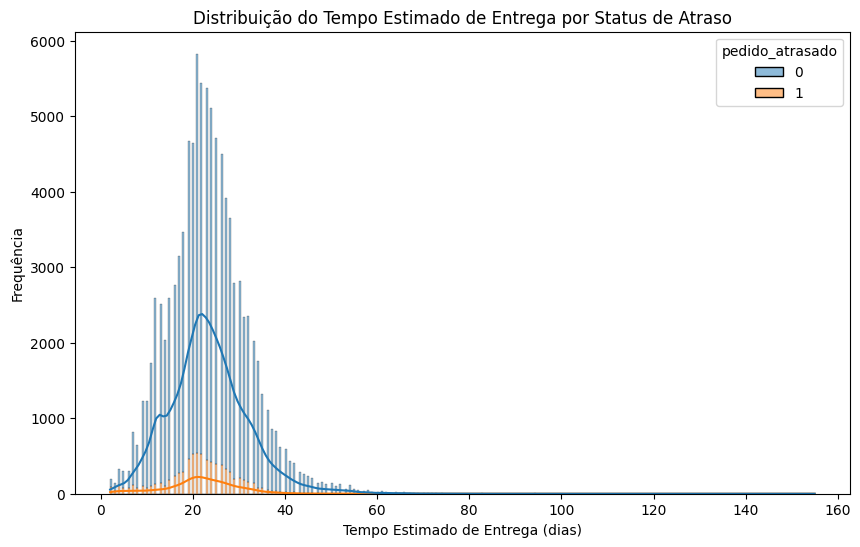

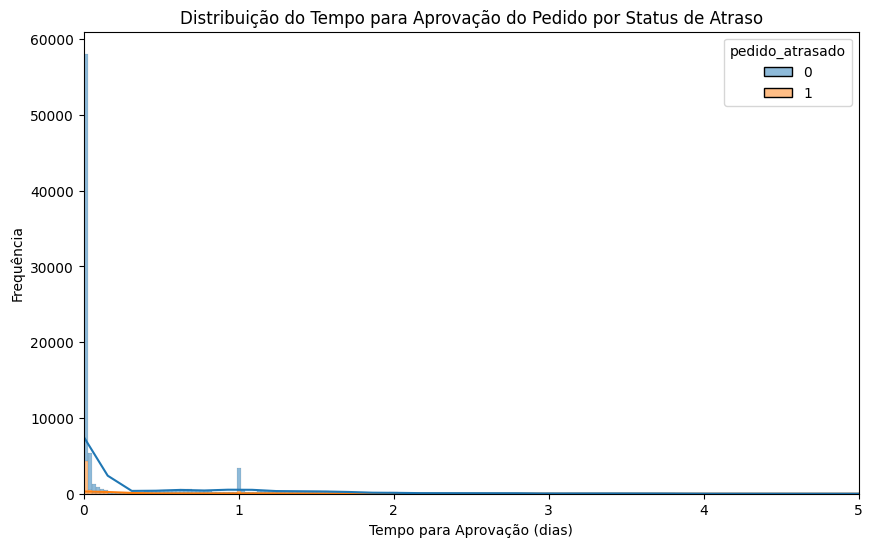

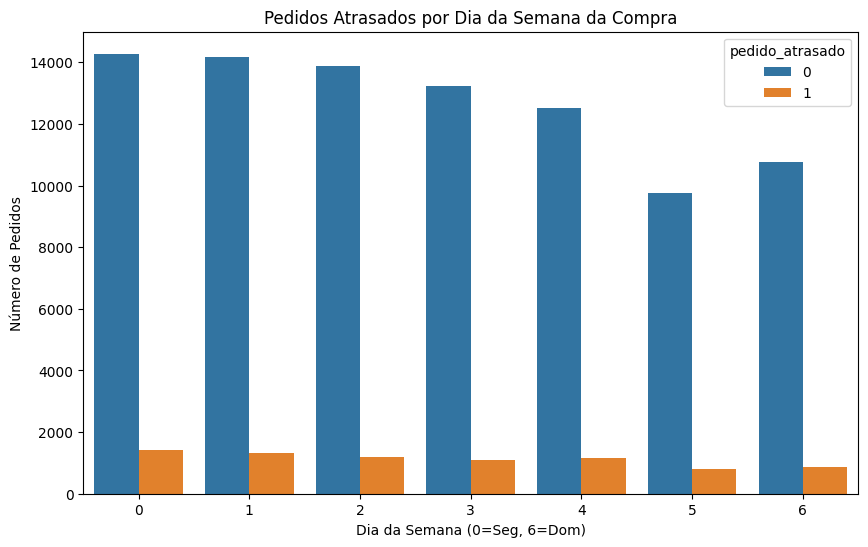

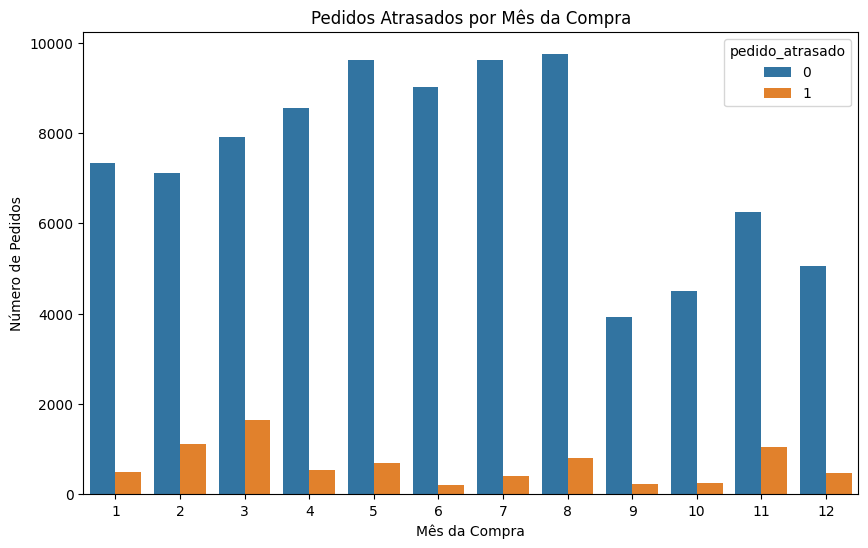

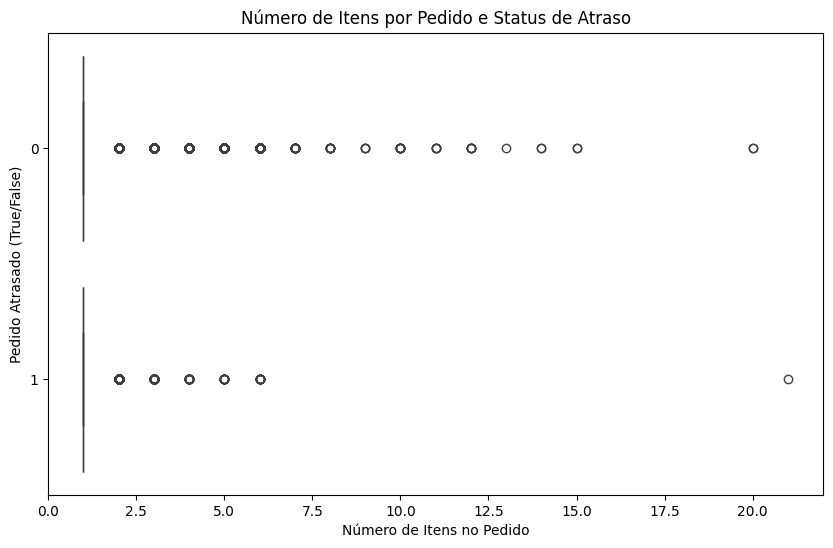

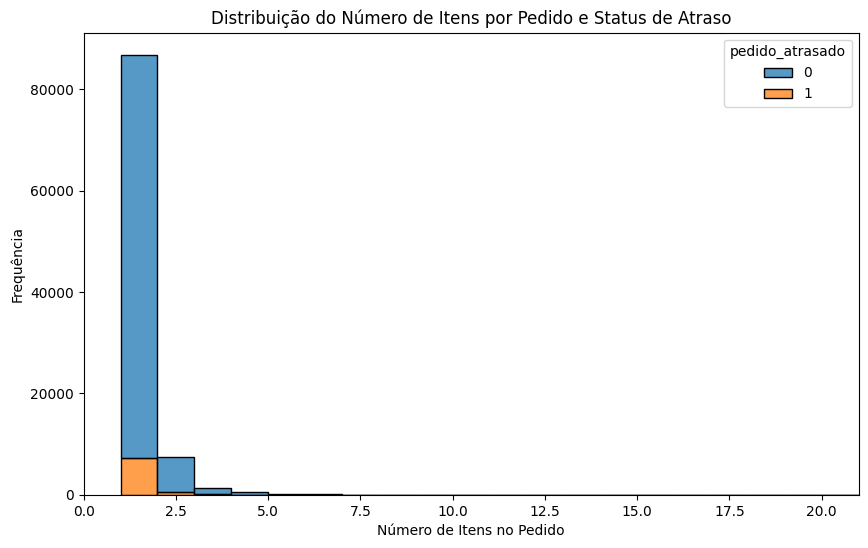

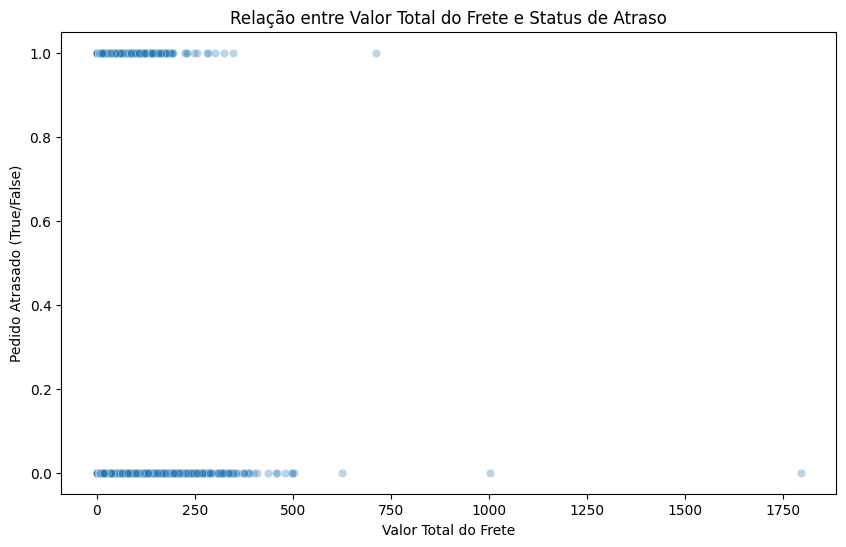

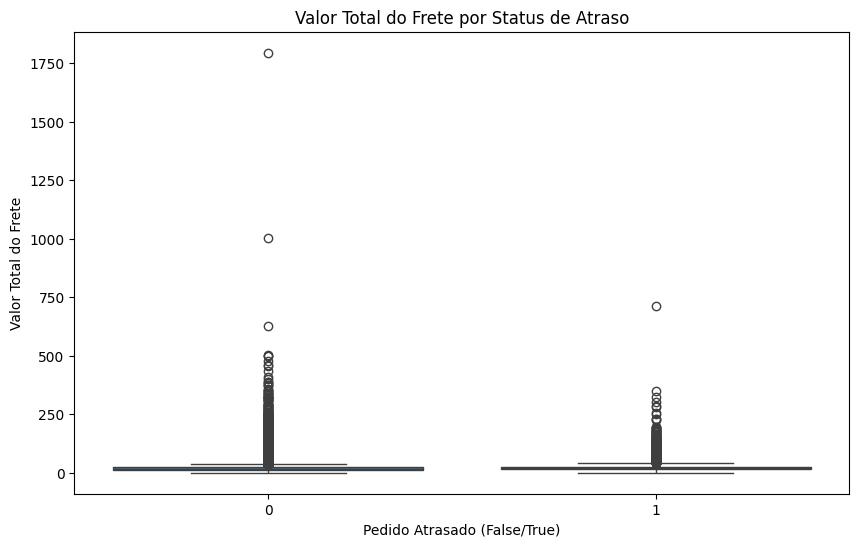

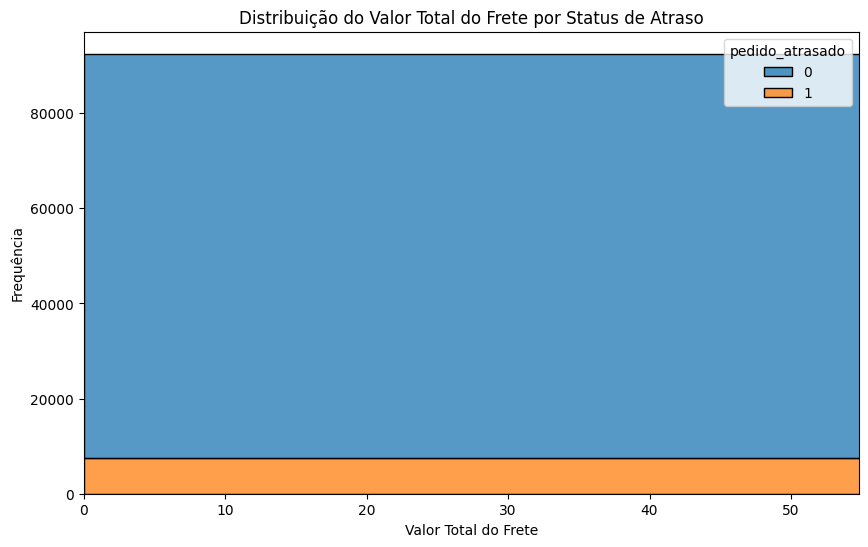


--- Métricas de Avaliação ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     17735
           1       0.33      0.00      0.00      1561

    accuracy                           0.92     19296
   macro avg       0.63      0.50      0.48     19296
weighted avg       0.87      0.92      0.88     19296

AUC-ROC: 0.5877


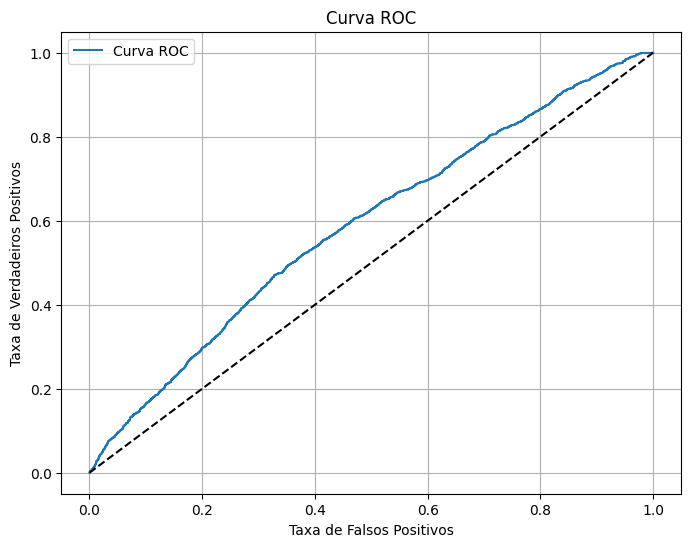

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- Features para Predição de Atraso ---
# Converter colunas de data para datetime
df_orders_cleaned['order_estimated_delivery_date'] = pd.to_datetime(df_orders_cleaned['order_estimated_delivery_date'])
df_orders_cleaned['order_delivered_customer_date'] = pd.to_datetime(df_orders_cleaned['order_delivered_customer_date'])

# Criar a coluna 'pedido_atrasado'
df_orders_cleaned['pedido_atrasado'] = (df_orders_cleaned['order_delivered_customer_date'] > df_orders_cleaned['order_estimated_delivery_date']).astype(int) # Converter para int

# Calcular o tempo estimado de entrega em dias
df_orders_cleaned['tempo_estimado_entrega'] = (df_orders_cleaned['order_estimated_delivery_date'] - df_orders_cleaned['order_purchase_timestamp']).dt.days

# Calcular o tempo para aprovação em dias
df_orders_cleaned['tempo_aprovacao'] = (df_orders_cleaned['order_approved_at'] - df_orders_cleaned['order_purchase_timestamp']).dt.total_seconds() / (60 * 60 * 24)
df_orders_cleaned['tempo_aprovacao'] = df_orders_cleaned['tempo_aprovacao'].apply(lambda x: max(0, x))

# Extrair dia da semana e mês da compra
df_orders_cleaned['dia_semana_compra'] = df_orders_cleaned['order_purchase_timestamp'].dt.dayofweek
df_orders_cleaned['mes_compra'] = df_orders_cleaned['order_purchase_timestamp'].dt.month

# Calcular número de itens por pedido
numero_itens_pedido = df_items.groupby('order_id')['order_item_id'].count().reset_index()
numero_itens_pedido.rename(columns={'order_item_id': 'numero_itens'}, inplace=True)
df_orders_cleaned = pd.merge(df_orders_cleaned, numero_itens_pedido, on='order_id', how='left')
df_orders_cleaned['numero_itens'].fillna(0, inplace=True)
df_orders_cleaned['numero_itens'] = df_orders_cleaned['numero_itens'].astype(int)

# Calcular valor total do frete por pedido
valor_frete_pedido = df_items.groupby('order_id')['freight_value'].sum().reset_index()
valor_frete_pedido.rename(columns={'freight_value': 'valor_total_frete'}, inplace=True)
df_orders_cleaned = pd.merge(df_orders_cleaned, valor_frete_pedido, on='order_id', how='left')
df_orders_cleaned['valor_total_frete'].fillna(0, inplace=True)

# Visualizações (manter aqui para inspeção, mas podem ser movidas para a explicação da abordagem)
plt.figure(figsize=(10, 6))
sns.histplot(data=df_orders_cleaned, x='tempo_estimado_entrega', hue='pedido_atrasado', kde=True, multiple='stack')
plt.title('Distribuição do Tempo Estimado de Entrega por Status de Atraso')
plt.xlabel('Tempo Estimado de Entrega (dias)')
plt.ylabel('Frequência')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_orders_cleaned, x='tempo_aprovacao', hue='pedido_atrasado', kde=True, multiple='stack')
plt.title('Distribuição do Tempo para Aprovação do Pedido por Status de Atraso')
plt.xlabel('Tempo para Aprovação (dias)')
plt.ylabel('Frequência')
plt.xlim(0, 5)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df_orders_cleaned, x='dia_semana_compra', hue='pedido_atrasado')
plt.title('Pedidos Atrasados por Dia da Semana da Compra')
plt.xlabel('Dia da Semana (0=Seg, 6=Dom)')
plt.ylabel('Número de Pedidos')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df_orders_cleaned, x='mes_compra', hue='pedido_atrasado')
plt.title('Pedidos Atrasados por Mês da Compra')
plt.xlabel('Mês da Compra')
plt.ylabel('Número de Pedidos')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='numero_itens', y='pedido_atrasado', data=df_orders_cleaned, orient='h')
plt.title('Número de Itens por Pedido e Status de Atraso')
plt.xlabel('Número de Itens no Pedido')
plt.ylabel('Pedido Atrasado (True/False)')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_orders_cleaned, x='numero_itens', hue='pedido_atrasado', multiple='stack', bins=20)
plt.title('Distribuição do Número de Itens por Pedido e Status de Atraso')
plt.xlabel('Número de Itens no Pedido')
plt.ylabel('Frequência')
plt.xlim(0, df_orders_cleaned['numero_itens'].max())
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='valor_total_frete', y='pedido_atrasado', data=df_orders_cleaned, alpha=0.3)
plt.title('Relação entre Valor Total do Frete e Status de Atraso')
plt.xlabel('Valor Total do Frete')
plt.ylabel('Pedido Atrasado (True/False)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='pedido_atrasado', y='valor_total_frete', data=df_orders_cleaned, orient='v')
plt.title('Valor Total do Frete por Status de Atraso')
plt.xlabel('Pedido Atrasado (False/True)')
plt.ylabel('Valor Total do Frete')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_orders_cleaned, x='valor_total_frete', hue='pedido_atrasado', multiple='stack', bins=30)
plt.title('Distribuição do Valor Total do Frete por Status de Atraso')
plt.xlabel('Valor Total do Frete')
plt.ylabel('Frequência')
plt.xlim(0, df_orders_cleaned['valor_total_frete'].quantile(0.95))
plt.show()


# --- Preparação dos Dados para o Modelo ---
# Selecionar as features (ajuste conforme necessário)
features = ['tempo_estimado_entrega', 'tempo_aprovacao', 'dia_semana_compra', 'mes_compra', 'numero_itens', 'valor_total_frete'] # Removi 'order_id'
target = 'pedido_atrasado'

# Verificar se as colunas existem no DataFrame
for col in features + [target]:
    if col not in df_orders_cleaned.columns:
        print(f"Coluna não encontrada: {col}")
        # Aqui você pode tratar o erro, por exemplo, removendo a coluna da lista
        features = [f for f in features if f != col]
        if col == target:
            target = None  # Defina o target como None para evitar erros futuros
        continue

if target is not None: # Garante que o target foi encontrado
    # Remover linhas com valores nulos nas features ou no target
    data = df_orders_cleaned[features + [target]].dropna()

    # Dividir os dados em treino e teste
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Escolha do Modelo ---
    # Modelo de exemplo: Regressão Logística (você pode experimentar outros)
    modelo = LogisticRegression(random_state=42, solver='liblinear') #solver importante para não ter warning

    # --- Treinamento do Modelo ---
    modelo.fit(X_train, y_train)

    # --- Avaliação do Modelo ---
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] # Probabilidades para a curva ROC

    print("\n--- Métricas de Avaliação ---")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Curva ROC')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal (classificador aleatório)
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Interpretação dos Resultados ---
    # (Adicionar texto explicativo sobre o desempenho do modelo)
    # Exemplo de texto: "O modelo de Regressão Logística obteve uma acurácia de X% na previsão de atrasos. A curva ROC mostra..."
else:
    print("Target variável 'pedido_atrasado' não encontrada. Impossível treinar o modelo.")



--- Receita Total: 14209250.31 ---

--- Número Total de Pedidos: 96476 ---


C:\Users\User\AppData\Local\Temp\ipykernel_13744\3246811421.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product_category_name', y='faturamento_total', data=faturamento_categorias_sql, palette='viridis')


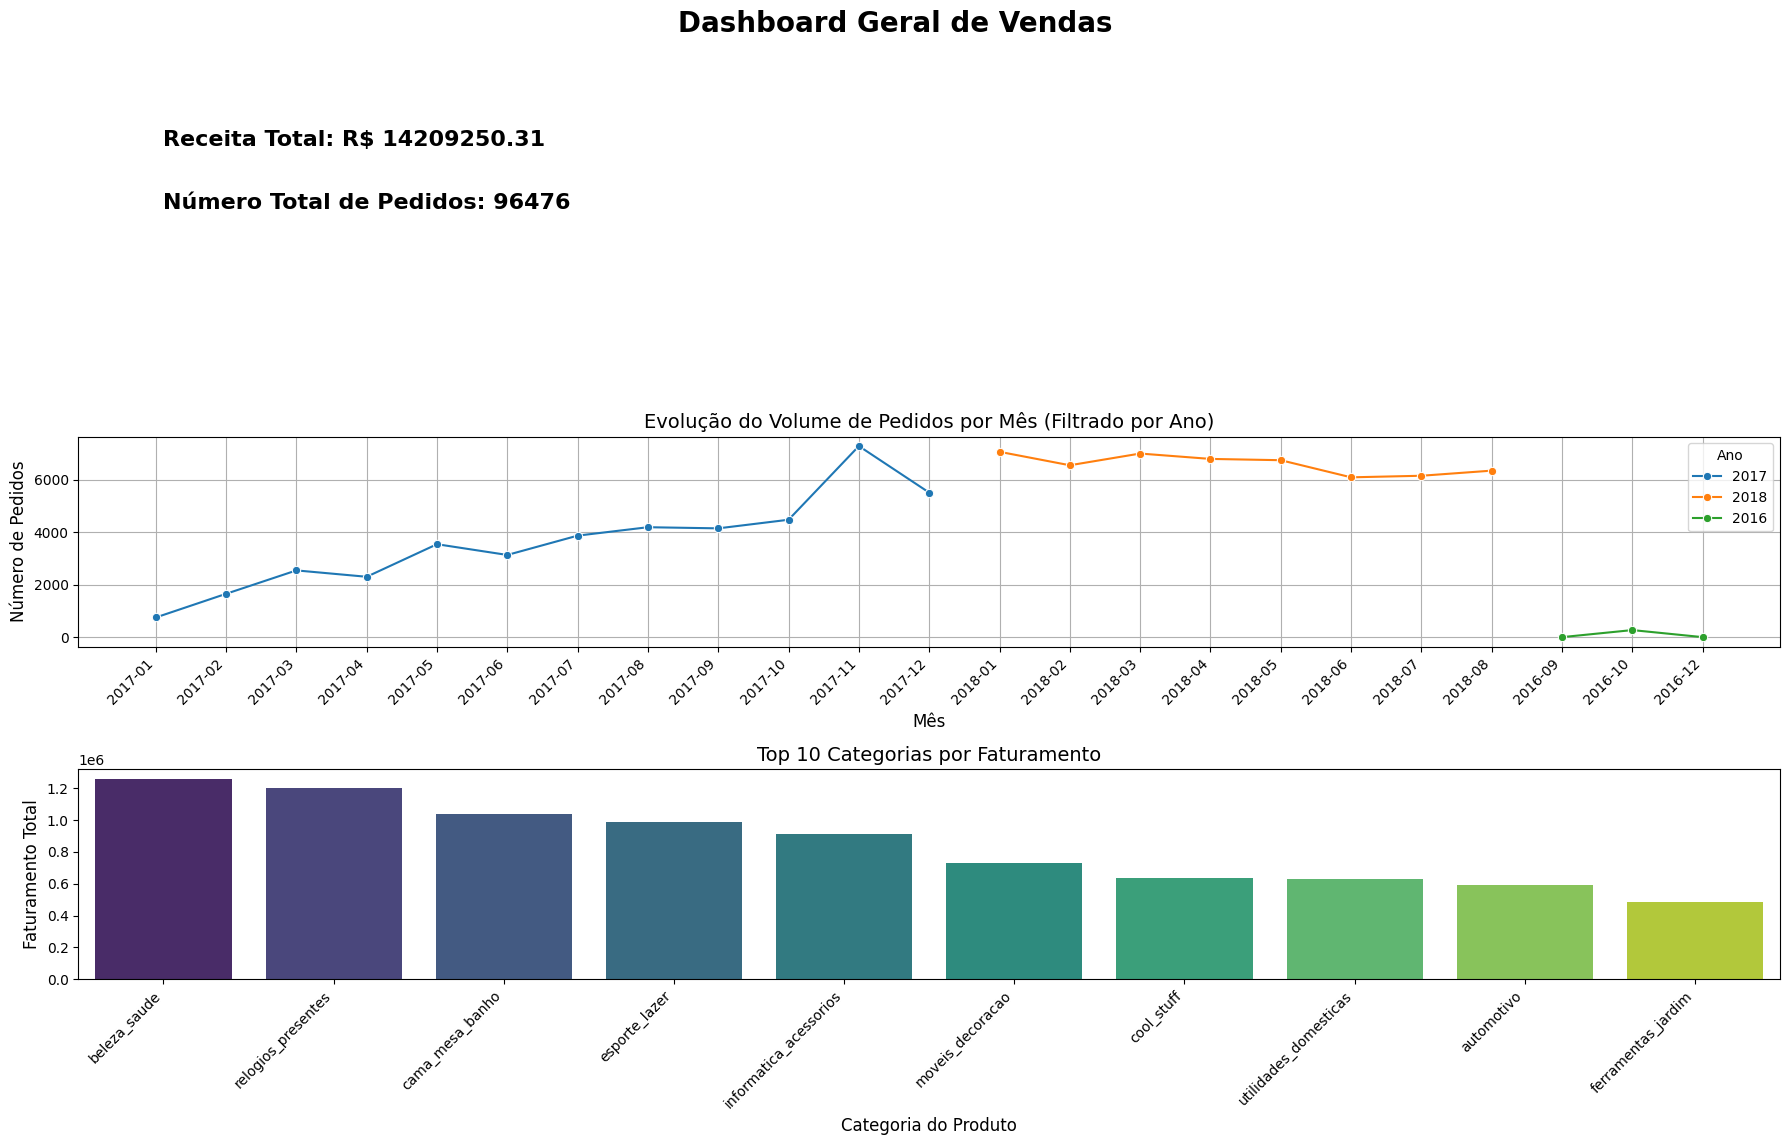


--- Erro ao gerar o Mapa de Calor: data/brasil_estados.shp: No such file or directory ---
Certifique-se de que o arquivo 'brasil_estados.shp' está na pasta 'data' e tente novamente.


In [4]:
# --- Dashboard Geral de Vendas ---
# Unir df_items e df_payments (se ainda não estiver unido)
if 'df_vendas_pagamentos' not in locals():
    df_vendas_pagamentos = pd.merge(df_items, df_payments, on='order_id', how='left')

# Calcular a receita total
receita_total = df_vendas_pagamentos['price'].sum()
print(f"\n--- Receita Total: {receita_total:.2f} ---")

# Calcular o número total de pedidos
numero_total_pedidos = df_orders_cleaned['order_id'].nunique()
print(f"\n--- Número Total de Pedidos: {numero_total_pedidos} ---")

# Preparar dados para o gráfico de linha (já feito anteriormente na AED)
# volume_pedidos_mensal_anual já deve estar calculado

# Criar a figura para o dashboard
plt.figure(figsize=(18, 12))
plt.suptitle('Dashboard Geral de Vendas', fontsize=20, fontweight='bold')

# Subplot para as métricas principais
plt.subplot(3, 1, 1) # 3 linhas, 1 coluna, primeiro subplot
plt.text(0.05, 0.8, f'Receita Total: R$ {receita_total:.2f}', fontsize=16, fontweight='bold')
plt.text(0.05, 0.5, f'Número Total de Pedidos: {numero_total_pedidos}', fontsize=16, fontweight='bold')
plt.axis('off') # Desativar os eixos deste subplot

# Subplot para o volume de pedidos ao longo do tempo (por ano)
plt.subplot(3, 1, 2) # 3 linhas, 1 coluna, segundo subplot
anos = df_orders_cleaned['purchase_year'].unique()
for i, ano in enumerate(anos):
    data_ano = volume_pedidos_mensal_anual[volume_pedidos_mensal_anual['ano'] == ano]
    sns.lineplot(x='mes_ano', y='total_pedidos', data=data_ano, marker='o', label=ano)
plt.title('Evolução do Volume de Pedidos por Mês (Filtrado por Ano)', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Número de Pedidos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(title='Ano')

# Executar a consulta SQL para o faturamento por categoria (se necessário)
if 'faturamento_categorias_sql' not in locals():
    query_faturamento_categorias = """
    SELECT
        p.product_category_name,
        SUM(oi.price) AS faturamento_total
    FROM items oi
    JOIN products p ON oi.product_id = p.product_id
    GROUP BY p.product_category_name
    ORDER BY faturamento_total DESC
    LIMIT 10;
    """
    # Supondo que você tenha uma função 'executar_sql' definida
    # faturamento_categorias_sql = executar_sql(query_faturamento_categorias)
    # Para agora, vamos usar pandas para simular (se df_pedidos_produtos existir)
    if 'df_pedidos_produtos' in locals():
        faturamento_categorias_sql = df_pedidos_produtos.groupby('product_category_name')['price'].sum().sort_values(ascending=False).head(10).reset_index(name='faturamento_total')
        faturamento_categorias_sql.rename(columns={'product_category_name': 'product_category_name'}, inplace=True)
    else:
        faturamento_categorias_sql = pd.DataFrame({'product_category_name': [], 'faturamento_total': []})


# Adicionar o subplot para o faturamento por categoria
plt.subplot(3, 1, 3) # 3 linhas, 1 coluna, terceiro subplot
if not faturamento_categorias_sql.empty:
    sns.barplot(x='product_category_name', y='faturamento_total', data=faturamento_categorias_sql, palette='viridis')
    plt.title('Top 10 Categorias por Faturamento', fontsize=14)
    plt.xlabel('Categoria do Produto', fontsize=12)
    plt.ylabel('Faturamento Total', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
else:
    plt.text(0.1, 0.5, 'Dados de faturamento por categoria não disponíveis para o dashboard.', fontsize=12)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar layout para o título principal
plt.show()

# --- Tentativa de Mapa de Calor ---
# (Mover para a seção de Visualização e Dashboards)
import geopandas as gpd
import matplotlib.pyplot as plt

# Tentar carregar o shapefile (lembre-se de ter o arquivo 'brasil_estados.shp' na pasta 'data' ou ajustar o caminho)
try:
    brasil = gpd.read_file('data/brasil_estados.shp')
    brasil = brasil.rename(columns={'UF': 'customer_state'})
    brasil_merged = brasil.set_index('customer_state').join(volume_pedidos_estado.set_index('customer_state'), how='left').fillna(0)
    brasil_merged['total_pedidos'] = brasil_merged['total_pedidos'].astype(int)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    brasil_merged.plot(column='total_pedidos', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.set_title('Volume de Pedidos por Estado do Cliente', fontsize=16)
    ax.set_axis_off()
    plt.show()

except Exception as e:
    print(f"\n--- Erro ao gerar o Mapa de Calor: {e} ---")
    print("Certifique-se de que o arquivo 'brasil_estados.shp' está na pasta 'data' e tente novamente.")